# Overview

This notebook attempts to understand the famous hand-written digit images dataset MNIST. We first tried visualizing the data to see what we are working with. Subsequently, we shall try different models on the dataset combined with some scaling and/or dimensionality reduction using PCA.

# Loading Necessary Libraries

In [70]:
from scipy import io
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time
from sklearn.decomposition import PCA
import math
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

%matplotlib inline

In [5]:
#do i want to run this?

import warnings
warnings.filterwarnings("ignore")

# Loading MNIST Data

In [6]:
#this is your downloaded file
data = io.loadmat('mnist-original.mat')

x, y = data['data'].T, data['label'].T
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# EDA

Let's visualize the data to see what we are dealing with.

In [7]:
display(x.shape,y.shape)

(70000, 784)

(70000, 1)

In [8]:
#no feature names hence create column label
data_df = pd.DataFrame(x.astype(np.float64))


#merging label to df of features
data_df['label'] = y


In [9]:
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0,70000.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0,4.452429
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0,2.890195
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,4.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,7.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0,9.000000


In [10]:
#check if any column contains any NaN
data_df[data_df.columns[data_df.isnull().any()]]

""
0
1
2
3
4
5
6
7
8
9


In [11]:
#check for data types
print(data_df.dtypes.unique())

[dtype('float64')]


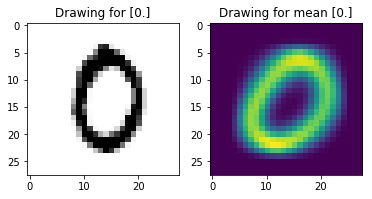

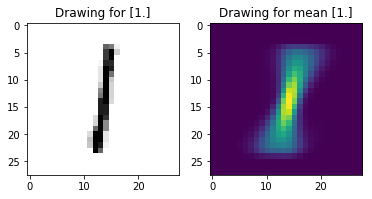

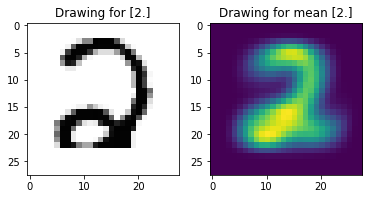

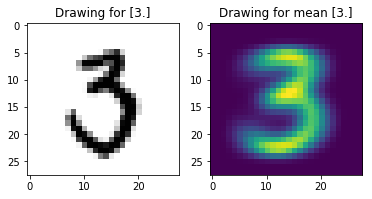

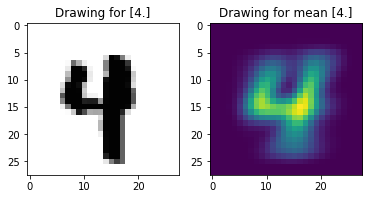

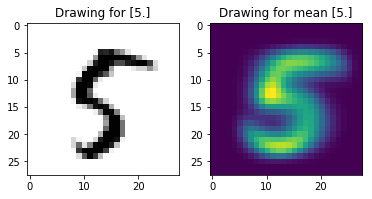

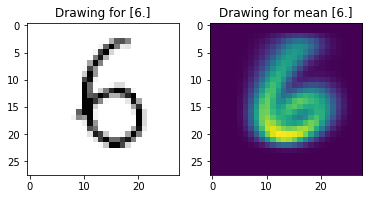

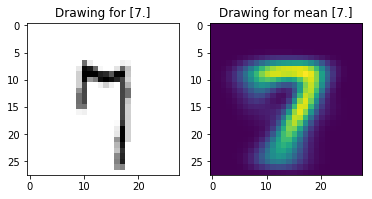

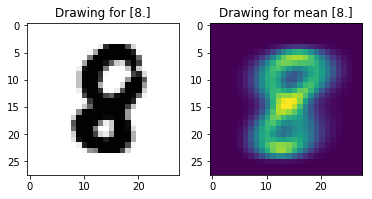

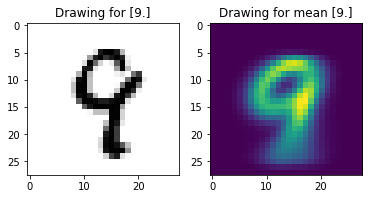

In [12]:
#sample an element for each class
for i, g in data_df.groupby('label'):
    #sampling to visualize 1 element for each class
    ele = g.sample(1)
    color_dots = ele.values[0][:-1]
    sub_dots = np.array_split(color_dots,len(color_dots)/28) #use reshape()
    
    sample_plot = plt.subplot(121)
    plt.imshow(sub_dots,cmap='Greys')
    plt.title(f'Drawing for {g["label"].unique()}')
    
    #calculate mean to visualize mean for each class
    avg_ele = g.mean(axis=0)
    avg_dots = avg_ele.values[:-1]
    
    avg_plot = plt.subplot(122)
    plt.imshow(np.array_split(avg_dots,len(avg_dots)/28))
    plt.title(f'Drawing for mean {g["label"].unique()}')
    
    plt.show()


# Modeling - Explore Regression with Dimensionality Reduction

In [13]:
%%time
logit = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='multinomial')

logit.fit(x_train, y_train.flatten())

CPU times: user 29.6 s, sys: 120 ms, total: 29.7 s
Wall time: 7.48 s


In [14]:
predicted_train = logit.predict(x_train)
predicted_test = logit.predict(x_test)

In [15]:
#non_pca_time = _
print(f'logistic model test score {accuracy_score(y_test, predicted_test)}')
print(f'logistic model train score {accuracy_score(y_train, predicted_train)}')

logistic model test score 0.9051428571428571
logistic model train score 0.9547428571428571


Reducing dimensionality can mean using PCA to change how we view the dataset. Let's see how it will perform after being transformed with PCA:

In [16]:
my_pca = PCA()

my_pca.fit(x_train)

x_pca_train = my_pca.transform(x_train)

x_pca_test = my_pca.transform(x_test)

# print(x_pca_train.shape)

In [17]:
%%time
pca_logit = LogisticRegression(solver='lbfgs', max_iter=200,multi_class='multinomial')

pca_logit.fit(x_pca_train,y_train.flatten())

CPU times: user 28.7 s, sys: 74.5 ms, total: 28.8 s
Wall time: 7.27 s


In [18]:
pca_predicted_test = pca_logit.predict(x_pca_test)
pca_predicted_train = pca_logit.predict(x_pca_train)

In [19]:
print(f'logistic model test score with PCA {accuracy_score(y_test, pca_predicted_test)}')
print(f'logistic model train score with PCA {accuracy_score(y_train, pca_predicted_train)}')

logistic model test score with PCA 0.9050857142857143
logistic model train score with PCA 0.9548


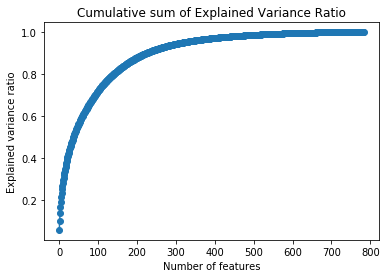

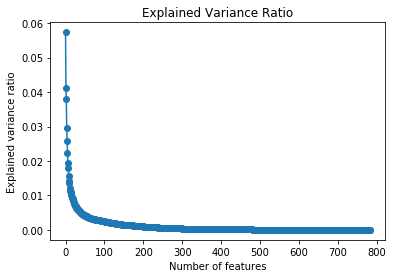

In [20]:
plt.plot(np.cumsum(my_pca.explained_variance_ratio_),marker='o')
plt.title('Cumulative sum of Explained Variance Ratio')
plt.xlabel('Number of features')
plt.ylabel('Explained variance ratio')
plt.show()

plt.plot(my_pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of features')
plt.ylabel('Explained variance ratio')
plt.show()

Looking at the "elbow" graphs at least hints that with some ~100 features, we can explain the variance. That means that we can 

Between the barebone and PCA-transformed logistic regressions, the times don't differ too much (~1 sec difference). The accuracy scores don't deviate much either.

What if we just guess based on the "elbow" graphs? I want to test the restored PCA-transformed version with the original images to see how that worked in train sets.

Let's run logistic regression again with a "magic" % of how well the variance is explained to keep.

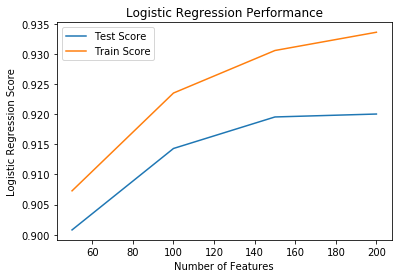

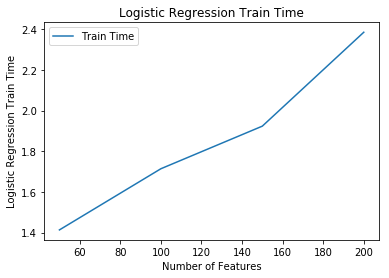

In [23]:
number_components = [50,100,150,200]

pca_train_time = []
pca_test_score = []
pca_train_score = []

for component in number_components:
    pca_test = PCA(n_components=component)

    x_train_try = pca_test.fit_transform(x_train) 
    x_test_try = pca_test.transform(x_test)

    t0 = time()
    
    logit_inversed_try = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='multinomial')
    logit_inversed_try.fit(x_train_try, y_train.flatten())
    
    pca_train_time.append(time()-t0)
    
    predicted_train_inversed_try = logit_inversed_try.predict(x_train_try)
    predicted_test_inversed_try = logit_inversed_try.predict(x_test_try)
    
    pca_test_score.append(accuracy_score(y_test, predicted_test_inversed_try))
    pca_train_score.append(accuracy_score(y_train, predicted_train_inversed_try))
    
plt.plot(number_components,pca_test_score,label='Test Score')
plt.plot(number_components,pca_train_score,label='Train Score')
plt.legend()
plt.title('Logistic Regression Performance')
plt.xlabel('Number of Features')
plt.ylabel('Logistic Regression Score')
plt.show()

plt.plot(number_components,pca_train_time,label='Train Time')
plt.legend()
plt.title('Logistic Regression Train Time')
plt.xlabel('Number of Features')
plt.ylabel('Logistic Regression Train Time')
plt.show()

In [24]:
print(f'Best train time is {pca_train_time[np.array(pca_train_time).argmin()]}')
print(f'logistic model inversed PCA test score {pca_test_score[np.array(pca_test_score).argmax()]}')
print(f'logistic model inversed PCA train score {pca_test_score[np.array(pca_train_score).argmax()]}')
print(f'Good PCA dimensions to keep: {number_components[np.array(pca_test_score).argmax()]}')

Best train time is 1.4132390022277832
logistic model inversed PCA test score 0.9200285714285714
logistic model inversed PCA train score 0.9200285714285714
Good PCA dimensions to keep: 200


It seems like the training time did drastically improve but the accuracy score suffered by a small margin of around ~3%!. Logistic regression relies on a linear function to compute a single values for multiple-features regression. hence the fewer features there are, the lesser time required to compute the values of f(x) to feed into sigmoid function, thus reducing the training time of logistic regression model. In models which rely on distances among points, reducing dimensionality also means reducing distance among points in the multi-dimensional space and consequently reduces computational effort to identify central positions among groups.

That being said, faster training time is not a holy grail advantage of dimensionality reduction as we also need to observe the trade-off of prediction accuracy (as observed above) as well as interpretability of data (when PCA amalgamate every features into new principle components where the first PC describes the most variance in chosen features and subsequent PCs with lesser degree.

Let's look at one example by plotting a data point in the new PCA space

In [26]:
pca_test = PCA(n_components=number_components[np.array(pca_test_score).argmax()])

x_train_90 = pca_test.fit_transform(x_train) 
x_test_90 = pca_test.transform(x_test)

Let's plot a sample inversed image from each group and compare to the original train set to see how they are "compressed".

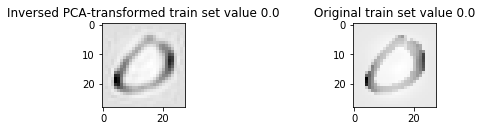

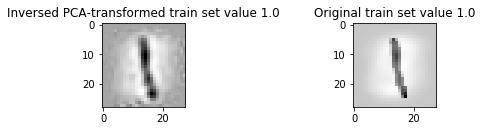

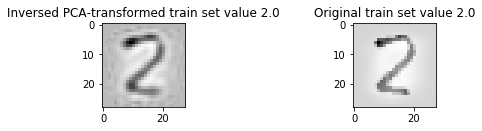

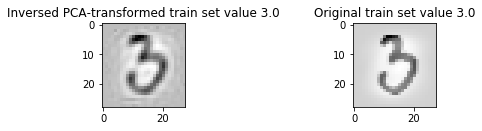

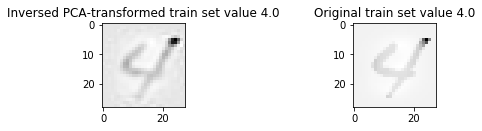

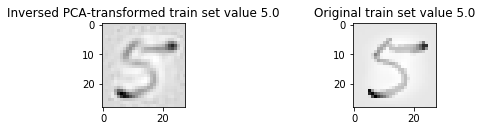

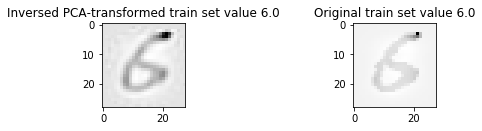

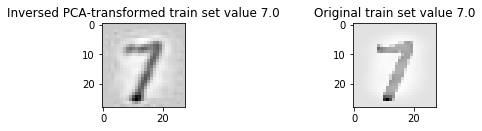

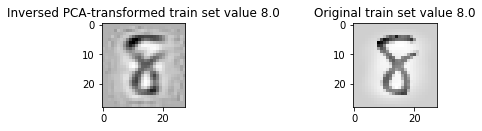

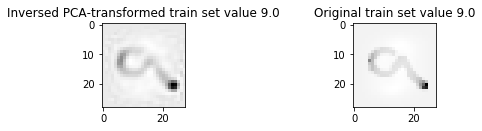

In [27]:
x_train_reversed_90 = pca_test.inverse_transform(x_train_90)
num_groups, num_indices = np.unique(np.array(y_train.flatten()),return_index=True)

for num, index in zip(num_groups,num_indices):
    plt.figaspect(30)
    inversed_sub_plot = plt.subplot(121)
    plt.imshow(x_train_reversed_90[index,:].reshape(28,28),cmap='Greys')
    plt.title(f'Inversed PCA-transformed train set value {num}')
    
    
    original_sub_plot = plt.subplot(122)
    plt.imshow(x_train[index,:].reshape(28,28),cmap='Greys')
    plt.title(f'Original train set value {num}')
     
    plt.subplots_adjust(wspace=2)
    plt.show()

Data points reduction will likely reduce logistic regression training time as there are fewer round of computations for the linear function. Let's run a new train/test split with smaller train size.

In [28]:
x_train_small, x_test_big, y_train_small, y_test_big = train_test_split(x, y, test_size=0.8)

In [29]:
%%time
logit_small_train = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='multinomial')

logit_small_train.fit(x_train_small, y_train_small.flatten())

CPU times: user 10.1 s, sys: 61.9 ms, total: 10.2 s
Wall time: 2.59 s


In [30]:
predicted_train_small = logit_small_train.predict(x_train_small)
predicted_test_big = logit_small_train.predict(x_test_big)

In [31]:
print(f'logistic model test score {accuracy_score(y_test_big, predicted_test_big)}')
print(f'logistic model train score {accuracy_score(y_train_small, predicted_train_small)}')

logistic model test score 0.8717142857142857
logistic model train score 0.9744285714285714


Timing for small train dataset is almost as good as the dimensionality-reduced scenario above. However, the scores suggest it's a case of overfitting since we did so poorly on the test set <-- disadvantage of data points reduction.

An alternative to reduce data points is create uniform random subset from the original dataset. This, however, requires multiple rounds of modelling to see the average performance.

# Modeling - Explore KNN Option


In [32]:
kfold = 5

#further subset the data to speed things up later on
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_train, y_train, test_size=0.5)

n_neighbours = [1,5,10,15]#,math.floor(len(x_train_sub)/kfold)]

validation_score_list = []

In [33]:
for neighbour in tqdm(n_neighbours):
    knn_model = KNeighborsClassifier(n_neighbors=neighbour,n_jobs=-1) #use all the cores in my machine
    validation_score = np.mean(cross_val_score(knn_model, x_train_sub, y_train_sub, cv = kfold))
    validation_score_list.append(validation_score)

100%|██████████| 4/4 [14:35<00:00, 217.47s/it]


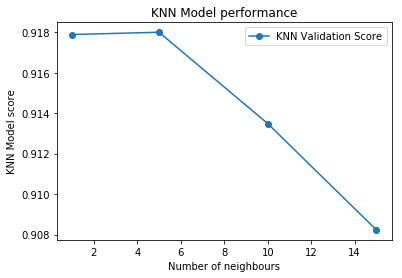

In [34]:
plt.plot(n_neighbours,validation_score_list,marker='o',label='KNN Validation Score')
plt.legend()
plt.title('KNN Model performance')
plt.xlabel('Number of neighbours')
plt.ylabel('KNN Model score')
plt.show()

Now we will model KNN with the maximum number of neighbours based on our subset train split.

In [35]:
knn_model_max = KNeighborsClassifier(n_neighbors=math.floor(len(x_train_sub)/kfold))
knn_model_max.fit(x_train_sub,y_train_sub)
print(f'Accuracy train score {knn_model_max.score(x_train_sub,y_train_sub)}')
print(f'Accuracy test score {knn_model_max.score(x_test_sub,y_test_sub)}')

Accuracy train score 0.3788
Accuracy test score 0.3730857142857143


As we increase the number of neighbours used to classify a data point, the more we open the classification to the effect of average and increasing bias (while reducing variance as we are "averaging" from more neighbours to decide classification). 

As bias increases, it's harder to distinguish images down to the pixel level (think we are now looking at bigger area to identify a class instead) hence the cross-validate scores drop along the increments of k number of neighbours.

Since we have identified a group of features from PCA transformation earlier on, let's use that for this question to save some time!

In [36]:
validation_score_90_list = []

n_neighbours.append(100)

for neighbour in tqdm(n_neighbours):
    knn_90_model = KNeighborsClassifier(n_neighbors=neighbour,n_jobs=-1) #use all the cores in my machine
    validation_score_90 = np.mean(cross_val_score(knn_model, x_train_90, y_train, cv = kfold))
    validation_score_90_list.append(validation_score_90)

100%|██████████| 5/5 [23:35<00:00, 283.64s/it]


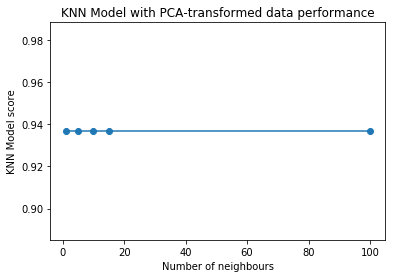

In [37]:
plt.plot(n_neighbours,validation_score_90_list,marker='o')
plt.title('KNN Model with PCA-transformed data performance')
plt.xlabel('Number of neighbours')
plt.ylabel('KNN Model score')
plt.show()

That's interesting the KNN for pca-transformed data shows the same score when changing the number of neighbours.

Let's proceed to test a decision tree with the subset to speed things up a little.

In [38]:
tree_depth = np.arange(1,11)
tree_cv_scores = []

for depth in tree_depth:
    tree_model = DecisionTreeClassifier(max_depth=depth)
    tree_cv_scores.append(np.mean(cross_val_score(tree_model, x_train_sub, y_train_sub, cv = kfold)))

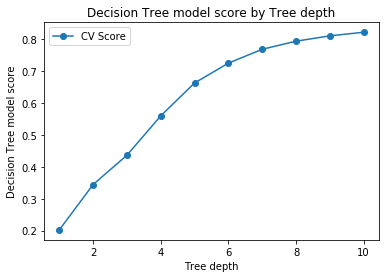

In [39]:
plt.plot(tree_depth,tree_cv_scores,label='CV Score',marker='o')
plt.legend()
plt.title('Decision Tree model score by Tree depth')
plt.xlabel('Tree depth')
plt.ylabel('Decision Tree model score')
plt.show()

In [40]:
post_cv_tree_model = DecisionTreeClassifier(max_depth=10)
post_cv_tree_model.fit(x_train_sub,y_train_sub)

predicted_tree = post_cv_tree_model.predict(x_test_sub)   
accuracy_score(y_test_sub,predicted_tree)

0.8281714285714286

As depth increases, the model is allowed to ask more and more questions to classify data. This should allow finer distinction among classes --> hence the positive trend of the cross-validation score.

# Modeling - Explore SVC Option

In [41]:
c_range = [0.001,0.01,0.1,1,10,100,1000]
linearsvc_scores = []
for c in tqdm(c_range):
    svm_model = LinearSVC(C=c)
    linearsvc_scores.append(np.mean(cross_val_score(svm_model, x_train_sub, y_train_sub, cv = kfold)))

100%|██████████| 7/7 [23:43<00:00, 218.60s/it]


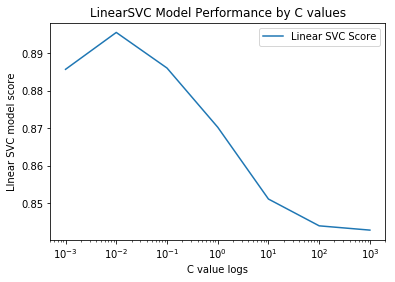

Best Linear SVC score is 0.8955460133753658
Best Linear SVC score is 0.01


In [42]:
plt.plot(c_range,linearsvc_scores,label='Linear SVC Score')
plt.xscale('log')
plt.legend()
plt.xlabel('C value logs')
plt.ylabel('LInear SVC model score')
plt.title('LinearSVC Model Performance by C values')
plt.show()

print(f'Best Linear SVC score is {np.array(linearsvc_scores).max()}')
print(f'Best Linear SVC score is {c_range[np.array(linearsvc_scores).argmax()]}')

In [43]:
svm_model_fixed = LinearSVC(C=c_range[np.array(linearsvc_scores).argmax()])
svm_model_fixed.fit(x_train_sub,y_train_sub)
print(f'New model score is {svm_model_fixed.score(x_test_sub,y_test_sub)}')

New model score is 0.9025714285714286


[[1665    0    5    4    4   17    9    5    7    1]
 [   0 1964   11    5    3    5    2    4   24    2]
 [  12   34 1527   36   29   14   24   31   58   10]
 [   8   15   50 1551    8   69   10   25   32   20]
 [   3   17    6    4 1625    5   16    7   19   64]
 [  23   11    6   37   23 1380   41   13   41   22]
 [  12   13   13    3   18   26 1584    0    6    1]
 [   8   21   22    9   28    2    0 1658    3   58]
 [  19   58   23   52   14   55   16    8 1354   26]
 [  20    8   11   37   73   16    2   61   12 1487]]


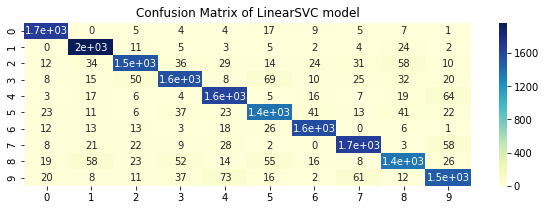

In [44]:
predicted_svm = svm_model_fixed.predict(x_test_sub)
confusion = confusion_matrix(y_test_sub, predicted_svm)

print(confusion)
plt.figure(figsize=(10,3))
sns.heatmap(confusion,annot=True,cmap='YlGnBu')
plt.title('Confusion Matrix of LinearSVC model')
plt.show()

Let's take a dive into a confusing pair: we will now separate the 4 and 9 classes. 

In [45]:
x_49 = np.array(data_df[(data_df['label']==9.0) | (data_df['label']==4.0) ].drop('label',axis=1))
y_49 = np.array(data_df[(data_df['label']==9.0) | (data_df['label']==4.0) ]['label'])

x_49_train, x_49_test, y_49_train, y_49_test = train_test_split(x_49, y_49, test_size=0.5)

scaler_49 = StandardScaler()
scaler_49.fit(x_49_train)
x_49_train = scaler_49.transform(x_49_train)
x_49_test = scaler_49.transform(x_49_test)

In [46]:
print(x_49.shape,y_49.shape)

(13782, 784) (13782,)


In [47]:
logit_49 = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='multinomial')

logit_49.fit(x_49_train, y_49_train.flatten())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

0.9605282252213031


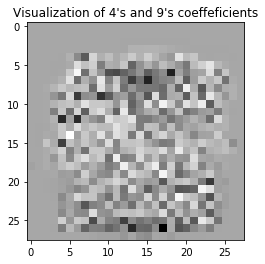

In [48]:
predicted_49 = logit_49.predict(x_49_test)

print(accuracy_score(y_49_test,predicted_49))

plt.imshow(logit_49.coef_.reshape(28,28),cmap='Greys')
plt.title('Visualization of 4\'s and 9\'s coeffeficients')
plt.show()

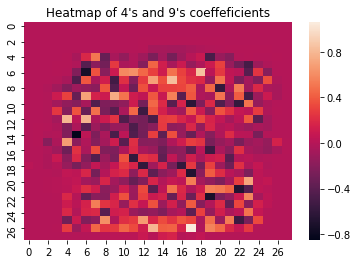

In [49]:
sns.heatmap(logit_49.coef_.reshape(28,28))
plt.title('Heatmap of 4\'s and 9\'s coeffeficients')
plt.show()

The heatmap as well as the image above showed areas where 4 and 9 drawings would not overlap. If we think about the mean images of 4 and 9 from question 2 above, we can see the two areas with the least overlap shown in the heatmap are centre top as well as centre bottom (similarly in the greyscale image with the overlapping areas having darker hues than the rest).

# Modeling - Explore Decistion Tree

Let's try randomforest to see if it fares better than Decision Tree.

In [54]:
param_dist = {"max_depth": [10,20,30,50,100],
              "n_estimators": [10,50,100,200],
              "criterion": ["gini", "entropy"]}

forest_classifier = RandomForestClassifier()

random_forest_search = RandomizedSearchCV(forest_classifier, cv=3, n_jobs=-1,verbose=6,n_iter=5, scoring='accuracy', param_distributions=param_dist)

random_forest_search.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:   17.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   26.4s remaining:   39.6s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   36.2s remaining:   24.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   40.4s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   51.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   51.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'max_depth': [10, 20, 30, 50, 100], 'n_estimators': [10, 50, 100, 200], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=6)

In [55]:
print(random_forest_search.best_params_)

{'n_estimators': 200, 'max_depth': 100, 'criterion': 'gini'}


In [56]:
randomforest_model = random_forest_search.best_estimator_#.get_params()['steps'][1][1]
randomforest_model.fit(x_train,y_train,)
predicted_opt = randomforest_model.predict(x_test)

print(accuracy_score(y_test,predicted_opt))

0.9653714285714285


In [73]:
confusion_forest = confusion_matrix(y_test, predicted_opt)

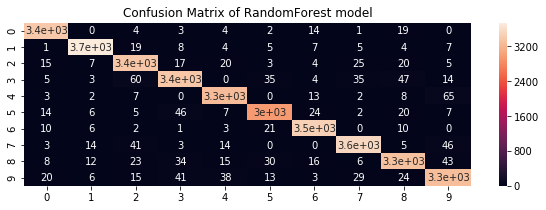

In [75]:
plt.figure(figsize=(10,3))
plt.title('Confusion Matrix of RandomForest model')
sns.heatmap(confusion_forest,annot=True)#,cmap='YlGnBu')
plt.show()

Looking decent although we are still misclassifying a bunch of numbers, especially for the case of 4-9, 3-9, 8-3, and 2-7.

# Modeling - Explore XGBoost

Let's try using XGBoost to see how well the model fare.

In [ ]:
params = {
        'max_depth': [20,30,50,100,200,300],
    'n_estimators':[50,100,200,300],
    'learning_rate':[0.01,0.1,1],
    'gamma':[0,0.001,0.01,0.1,1]
        }

xgb = XGBClassifier(objective='multi:softmax', silent=True)

folds = 3

param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=skf.split(x_train,y_train), verbose=6 )

random_search.fit(x_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed: 28.6min remaining: 114.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 122.7min remaining: 184.0min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed: 134.0min remaining: 89.3min


In [ ]:
print(random_search.best_params_)

xgb_opt = random_search.best_estimator_

xgb_opt.fit(x_train,y_train,eval_metric=["error"],verbose=True,eval_set=[(x_train, y_train), (x_test, y_test)])
xgb_predicted = xgb_opt.predict(x_test)

print(accuracy_score(y_test,xgb_predicted))

That was not bad but sure took a very long time. Let's plot some evaluation to see how it fared.

In [ ]:
eval_results = xgb_opt.evals_result()

In [ ]:
xgb_opt_xaxis = range(len(results['validation_0']['error']))

plt.plot(xgb_opt_xaxis,results['validation_0']['error'], label='Train')
plt.plot(xgb_opt_xaxis,results['validation_1']['error'], label='Test')
plt.title('XGBoost classification error')
plt.ylabel('Classification error')
plt.legend()
plt.show()